In [1]:
import numpy as np

In [2]:
line1 = "# ombh2 omch2 w0 ns ln10As H0 Neff sigma8"
line2 = "2.268324999999999855e-02 1.140598000000000029e-01 -8.165972000000000230e-01 9.755890000000000395e-01 3.092918000000000056e+00 6.336569000000000074e+01 2.918750000000000178e+00 7.730715000000000225e-01"

In [3]:
import math
from scipy.integrate import quad, fixed_quad
import matplotlib.pyplot as plt
import pickle 
import numpy as np
import functools

G = 4.3009e-9 #km^2 Mpc/ (Msolar  s^2) weird units to make rhom_a good units 

def M_to_R(M, box, a):
    """
    Converts mass of top-hat filter to radius of top-hat filter
    
    Parameters:
        - M (float): Mass of the top hat filter in units Msolor/h
        - box (string): Which Aemulus nu box we're considering 
        - a (float): Redshift 

    Returns:
        - R (float): Corresponding radius of top hat filter Mpc/h
    """

    return (M / (4/3 * math.pi * rhom_a(box, a))) ** (1/3) # h^-1 Mpc  

def R_to_M(R,box, a):
    """
    Converts radius of top-hat filter to mass of top-hat filter
    
    Parameters:
        - R (float): Radius of the top hat filter in units Mpc/h
        - box (string): Which Aemulus nu box we're considering 
        - a (float): Redshift 

    Returns:
        - M (float): Corresponding mass of top hat filter Msolar/h 
    """
    return R ** 3 * 4/3 * math.pi * rhom_a(box, a)

def scaleToRedshift(a):
    return 1/a-1

def redshiftToScale(z):
    return 1/(1+z)

def sigma2(pk, R):
    """
    Adapated from https://github.com/komatsu5147/MatterPower.jl
    Computes variance of mass fluctuations with top hat filter of radius R
    For this function let k be the comoving wave number with units h/Mpc
    MODIFIED TO MATCH TINKER
    Parameters:
        - pk (funtion): P(k), the matter power spectrum which has units Mpc^3 / h^3
        - R (float): The smoothing scale in units Mpc/h
    Returns:
        - sigma2 (float): The variance of mass fluctuations
    """

    def dσ2dk(k):
        x = k * R
        W = (3 / x) * (np.sin(x) / x**2 - np.cos(x) / x)
        dσ2dk = W * pk(k) * k**2 / 2 / np.pi**2
        return dσ2dk
    res, err = quad(dσ2dk, 0, np.inf)
    σ2 = res
    return σ2

def rhom_a(box, a):
    '''comoving'''
    ombh2 = cosmo['ombh2']
    omch2 = cosmo['omch2']
    H0 = cosmo['H0'] #[km s^-1 Mpc-1]
    h = H0/100 

    Ωm = ombh2/h**2 + omch2/h**2
    
    ΩDE = 1 - Ωm
    wDE = cosmo['w0'] #'wa' is zero for us

    ρcrit0 = 3*H0**2/(8*np.pi*G)/h**2 # h^2 Msol/Mpc^3
    return Ωm*ρcrit0*(Ωm*a**(-3) + ΩDE*a**(-3*(1+wDE)))*a**3  # h^2 Msol/Mpc^3 
    
def dsigma2dR(pk, R):
    """
    Adapated from https://github.com/komatsu5147/MatterPower.jl
    Computes deriative of variance of mass fluctuations wrt top hat filter of radius R
    For this function let k be the comoving wave number with units h/Mpc
    
    Parameters:
        - pk (funtion): P(k), the matter power spectrum which has units Mpc^3 / h^3
        - R (float): The smoothing scale in units Mpc/h
    Returns:
        - dsigma2dR (float): The derivative of the variance of mass fluctuations wrt R
    """

    def dσ2dRdk(k):
        x = k * R
        W = (3 / x) * (np.sin(x) / x**2 - np.cos(x) / x)
        dWdx = (-3 / x) * ((3 / x**2 - 1) * np.sin(x) / x - 3 * np.cos(x) / x**2)
        dσ2dRdk = 2 * W * dWdx * pk(k) * k**3 / 2 / np.pi**2
        return dσ2dRdk
    res, err = quad(dσ2dRdk, 0, 20 / R)
    return res

def dRdM(M, box, a):
    return 1/(6**(2/3)*np.pi**(1/3)*M**(2/3)*rhom_a(box, a)**(1/3))

In [4]:
columns = [col for col in line1.split()[1:]]
cosmo  = dict(zip(columns, np.array(line2.split(), dtype=np.float64)))
print(cosmo)

{'ombh2': 0.02268325, 'omch2': 0.1140598, 'w0': -0.8165972, 'ns': 0.975589, 'ln10As': 3.092918, 'H0': 63.36569, 'Neff': 2.91875, 'sigma8': 0.7730715}


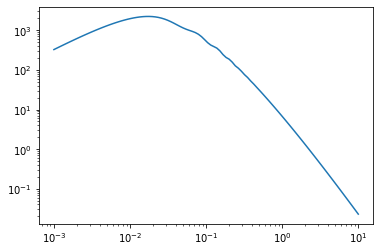

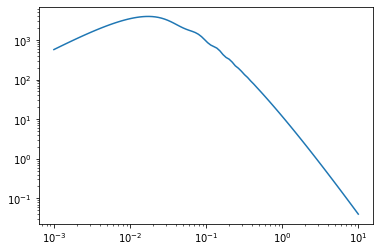

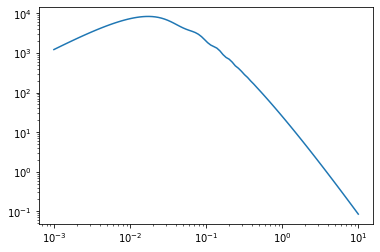

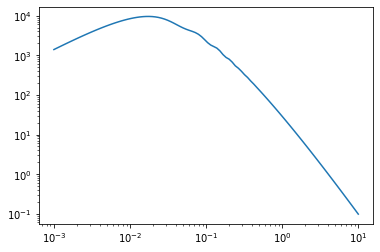

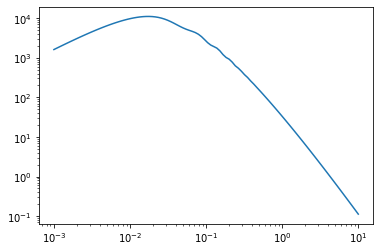

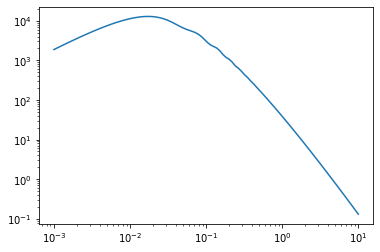

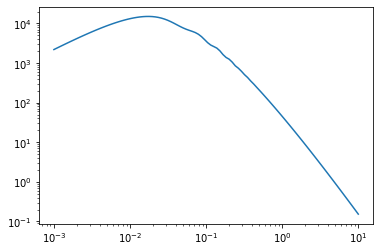

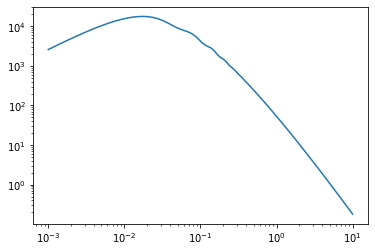

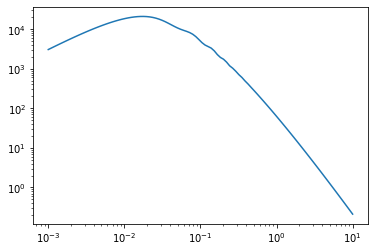

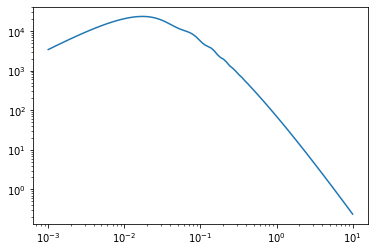

In [5]:
from tqdm import tqdm, trange
from classy import Class
import pickle


h = cosmo['H0']/100
# cosmo_dict = {
#     'h': h,
#     'Omega_b': cosmo['ombh2'] / h**2,
#     'Omega_cdm': cosmo['omch2'] / h**2,
#     'output': 'mPk mTk',
#     'z_pk': '0.0,99',
#     'P_k_max_h/Mpc': 20.,
#     'T_cmb': 2.7255,
#     'ln10^{10}A_s': cosmo['ln10As'],
#     'n_s': cosmo['ns'],
#     'Omega_Lambda': 0.0,
#     'w0_fld': cosmo['w0'],
#     'wa_fld': 0.0,
#     'cs2_fld': 1.0,
#     'fluid_equation_of_state': "CLP",
#     'N_eff':cosmo['Neff']
# }
#old version from https://github.com/tmcclintock/aemulus_simulation_testing/blob/7a95750d006aea23388f5ce29cb05ad4490ae09e/version2/newtest_script.py#L61
Omega_b = cosmo['ombh2'] / h**2
Omega_c = cosmo['omch2'] / h**2
Omega_m = Omega_b+Omega_c

cosmo_dict = {'output': 'mPk', 
              'h': h, 
              'ln10^{10}A_s': cosmo['ln10As'],
              'n_s': cosmo['ns'],
              'w0_fld': cosmo['w0'],
              'wa_fld': 0.0, 
              'Omega_b': cosmo['ombh2'] / h**2,
              'Omega_cdm': cosmo['omch2'] / h**2,
              'Omega_Lambda': 1.- Omega_m, 
              'N_eff':cosmo['Neff'],
              'P_k_max_1/Mpc':10., 
              'z_max_pk':10. }
pkclass = Class()
pkclass.set(cosmo_dict)
pkclass.compute()

box = 'Box000'
curr_run_fname = "/oak/stanford/orgs/kipac/aemulus/aemulus_alpha/" + box + "/";
rockstar_dir = curr_run_fname + "halos/m200b/"

N_snapshots = 10
a = []
for i in range(N_snapshots):
    f = open(rockstar_dir+'out_%d.list'%(i), 'r')

    for line in f:
        if('#a' in line):
            a+= [eval(line.split()[2])]
            break


zs = [scaleToRedshift(a_curr) for a_curr in a]

Pkz = {}
for z in  zs:
    kt = np.logspace(-3, 1, 100) # h/Mpc
    pk_m_lin = np.array(
        [
            pkclass.pk_lin(ki, np.array([z]))*h**3 #units of Mpc^3/h^3
            for ki in kt * h # 1 / Mpc
        ]
    )
    from scipy.interpolate import interp1d
    #given k in units of h/Mpc gives Pk in units of Mpc^3/h^3 
    Pk = interp1d(kt, pk_m_lin, kind='linear', bounds_error=False, fill_value=0.)

    Pkz[z] = Pk    
#     class_sigma8 = pkclass.sigma(8, z, h_units=True)
#     my_sigma8 = np.sqrt(sigma2(Pk, 8)) # 8 h^-1 Mpc
#     print(class_sigma8, my_sigma8)
#     assert(np.abs(class_sigma8-my_sigma8)<0.01*class_sigma8)
    plt.plot(kt, Pk(kt))
    plt.xscale('log')
    plt.yscale('log')
    plt.show()


In [6]:
Pk_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/alpha_check/'+box+'_Pk.pkl'
Pk_f = open(Pk_fname, 'wb')
pickle.dump(Pkz, Pk_f)
Pk_f.close()

In [7]:
pkclass.sigma(8, z, h_units=True)

0.8139817979822095

In [8]:
np.sqrt(sigma2(Pk, 8))

/tmp/ipykernel_15592/2460845013.py:63: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)


0.9485547533620394

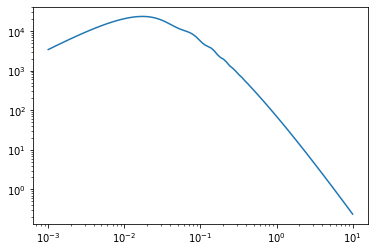

In [9]:
plt.plot(kt, Pk(kt))
plt.xscale('log')
plt.yscale('log')